In [1]:
from keras.datasets import boston_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.regularizers import l2, l1
from sklearn.model_selection import KFold
import random
random.seed(1234)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# I run this console in kaggle, therefore we could see this IO rather than directly load_data()
train_data= pd.read_csv('../input/train_data.csv', usecols=range(1,14))
train_targets = pd.read_csv('../input/train_targets.csv', usecols=range(1,2))
test_data = pd.read_csv('../input/test_data.csv', usecols=range(1,14))
test_targets = pd.read_csv('../input/test_targets.csv', usecols=range(1,2))
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [3]:
def k_fold_eval(train_data, train_targets, network, num_epoch, num_batch):
    k = 10
    num_val_samples = len(train_data) // k
    all_scores = []
    histories = []
    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],
                                               axis=0)
        history = network.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=num_batch, verbose=0)
        histories.append(history)
        val_mse = history.history['val_mean_squared_error']
        all_scores.append(val_mse)
    return all_scores, histories

In [4]:
class Network():
    def __init__(self, epcohs):
        self._model = models.Sequential()
    def compile(self):
        self._model.add(layers.Dense(1))
        self._model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])   
    def baseline(self):
        self._model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, activation='relu'))
        self.compile()
    def dropout(self):
        self._model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dropout(0.5))
        self._model.add(layers.Dense(64, activation='relu'))
        self._model.add(layers.Dropout(0.5))
        self.compile()
    def l1(self):
        self._model.add(layers.Dense(64, kernel_regularizer=l1(0.001), activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, kernel_regularizer=l1(0.001), activation='relu'))
        self.compile()
    def l2(self):
        self._model.add(layers.Dense(64, kernel_regularizer=l2(0.001), activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, kernel_regularizer=l2(0.001), activation='relu'))
        self.compile()
    def get_network(self):
        return self._model

In [5]:
num_epochs = 200
num_batches = 20
network = Network(num_epochs)
network.baseline()
network1 = network.get_network()
network = Network(num_epochs)
network.dropout()
network2 = network.get_network()
network = Network(num_epochs)
network.l1()
network3 = network.get_network()
network = Network(num_epochs)
network.l2()
network4 = network.get_network()
scores1, histroies1 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores2, histroies2 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores3, histroies3 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores4, histroies4 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [6]:
mse1 = [np.mean([x[i] for x in scores1]) for i in range(num_epochs)]
mse2 = [np.mean([x[i] for x in scores2]) for i in range(num_epochs)]
mse3 = [np.mean([x[i] for x in scores3]) for i in range(num_epochs)]
mse4 = [np.mean([x[i] for x in scores4]) for i in range(num_epochs)]

Text(0.5,1,'Validation MSE by Comparison')

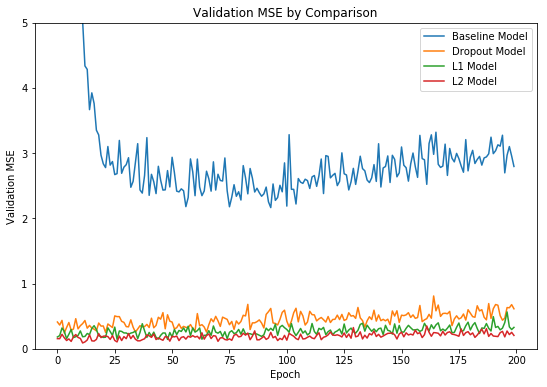

In [7]:
plt.figure(figsize=(9,6))
nxvals = np.arange(0,200)
plt.plot(nxvals, mse1, label='Baseline Model')
plt.plot(nxvals, mse2, label='Dropout Model')
plt.plot(nxvals, mse3, label='L1 Model')
plt.plot(nxvals, mse4, label='L2 Model')
plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.ylim(0,5)
plt.legend(loc='best')
plt.title("Validation MSE by Comparison")

In [8]:
histroies1[0].history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

In [9]:
final = Network(500)
final.l2()
network_final = final.get_network()
network_final.fit(train_data, train_targets, epochs=500, batch_size=12)

Epoch 1/500
404/404 [==============================] - 0s 863us/step - loss: 456.5148 - mean_squared_error: 456.4258
Epoch 2/500
404/404 [==============================] - 0s 254us/step - loss: 206.5050 - mean_squared_error: 206.4065
Epoch 3/500
404/404 [==============================] - 0s 260us/step - loss: 64.8227 - mean_squared_error: 64.7146
Epoch 4/500
404/404 [==============================] - 0s 254us/step - loss: 34.0474 - mean_squared_error: 33.9363
Epoch 5/500
404/404 [==============================] - 0s 257us/step - loss: 25.6294 - mean_squared_error: 25.5189
Epoch 6/500
404/404 [==============================] - 0s 280us/step - loss: 21.5639 - mean_squared_error: 21.4549
Epoch 7/500
404/404 [==============================] - 0s 281us/step - loss: 19.0381 - mean_squared_error: 18.9305
Epoch 8/500
404/404 [==============================] - 0s 274us/step - loss: 16.8731 - mean_squared_error: 16.7660
Epoch 9/500
404/404 [==============================] - 0s 275us/step - loss:

404/404 [==============================] - 0s 311us/step - loss: 5.8915 - mean_squared_error: 5.7639
Epoch 73/500
404/404 [==============================] - 0s 307us/step - loss: 5.9535 - mean_squared_error: 5.8255
Epoch 74/500
404/404 [==============================] - 0s 311us/step - loss: 6.0615 - mean_squared_error: 5.9330
Epoch 75/500
404/404 [==============================] - 0s 308us/step - loss: 5.7798 - mean_squared_error: 5.6508
Epoch 76/500
404/404 [==============================] - 0s 322us/step - loss: 6.0033 - mean_squared_error: 5.8737
Epoch 77/500
404/404 [==============================] - 0s 364us/step - loss: 5.5767 - mean_squared_error: 5.4465
Epoch 78/500
404/404 [==============================] - 0s 334us/step - loss: 5.9347 - mean_squared_error: 5.8043
Epoch 79/500
404/404 [==============================] - 0s 310us/step - loss: 5.7992 - mean_squared_error: 5.6683
Epoch 80/500
404/404 [==============================] - 0s 371us/step - loss: 5.4989 - mean_squared_e

404/404 [==============================] - 0s 319us/step - loss: 3.6516 - mean_squared_error: 3.4929
Epoch 144/500
404/404 [==============================] - 0s 305us/step - loss: 3.8164 - mean_squared_error: 3.6572
Epoch 145/500
404/404 [==============================] - 0s 303us/step - loss: 3.7198 - mean_squared_error: 3.5603
Epoch 146/500
404/404 [==============================] - 0s 307us/step - loss: 3.7385 - mean_squared_error: 3.5786
Epoch 147/500
404/404 [==============================] - 0s 313us/step - loss: 3.7407 - mean_squared_error: 3.5807
Epoch 148/500
404/404 [==============================] - 0s 311us/step - loss: 3.5979 - mean_squared_error: 3.4372
Epoch 149/500
404/404 [==============================] - 0s 303us/step - loss: 3.6470 - mean_squared_error: 3.4860
Epoch 150/500
404/404 [==============================] - 0s 310us/step - loss: 3.6625 - mean_squared_error: 3.5011
Epoch 151/500
404/404 [==============================] - 0s 310us/step - loss: 3.5983 - mean_s

404/404 [==============================] - 0s 298us/step - loss: 2.7662 - mean_squared_error: 2.5829
Epoch 215/500
404/404 [==============================] - 0s 304us/step - loss: 2.5731 - mean_squared_error: 2.3897
Epoch 216/500
404/404 [==============================] - 0s 361us/step - loss: 2.8339 - mean_squared_error: 2.6499
Epoch 217/500
404/404 [==============================] - 0s 347us/step - loss: 2.5587 - mean_squared_error: 2.3746
Epoch 218/500
404/404 [==============================] - 0s 309us/step - loss: 2.6466 - mean_squared_error: 2.4622
Epoch 219/500
404/404 [==============================] - 0s 326us/step - loss: 2.6024 - mean_squared_error: 2.4178
Epoch 220/500
404/404 [==============================] - 0s 306us/step - loss: 2.7862 - mean_squared_error: 2.6011
Epoch 221/500
404/404 [==============================] - 0s 307us/step - loss: 2.4802 - mean_squared_error: 2.2950
Epoch 222/500
404/404 [==============================] - 0s 305us/step - loss: 2.6066 - mean_s

404/404 [==============================] - 0s 320us/step - loss: 2.0934 - mean_squared_error: 1.8926
Epoch 286/500
404/404 [==============================] - 0s 302us/step - loss: 1.8914 - mean_squared_error: 1.6904
Epoch 287/500
404/404 [==============================] - 0s 314us/step - loss: 2.0809 - mean_squared_error: 1.8798
Epoch 288/500
404/404 [==============================] - 0s 302us/step - loss: 2.0026 - mean_squared_error: 1.8013
Epoch 289/500
404/404 [==============================] - 0s 318us/step - loss: 2.1062 - mean_squared_error: 1.9047
Epoch 290/500
404/404 [==============================] - 0s 357us/step - loss: 1.9847 - mean_squared_error: 1.7833
Epoch 291/500
404/404 [==============================] - 0s 299us/step - loss: 1.9871 - mean_squared_error: 1.7852
Epoch 292/500
404/404 [==============================] - 0s 320us/step - loss: 2.0054 - mean_squared_error: 1.8034
Epoch 293/500
404/404 [==============================] - 0s 315us/step - loss: 1.9735 - mean_s

404/404 [==============================] - 0s 306us/step - loss: 1.5823 - mean_squared_error: 1.3686
Epoch 357/500
404/404 [==============================] - 0s 314us/step - loss: 1.5577 - mean_squared_error: 1.3438
Epoch 358/500
404/404 [==============================] - 0s 305us/step - loss: 1.6758 - mean_squared_error: 1.4618
Epoch 359/500
404/404 [==============================] - 0s 312us/step - loss: 1.7651 - mean_squared_error: 1.5508
Epoch 360/500
404/404 [==============================] - 0s 319us/step - loss: 1.5607 - mean_squared_error: 1.3463
Epoch 361/500
404/404 [==============================] - 0s 308us/step - loss: 1.6424 - mean_squared_error: 1.4281
Epoch 362/500
404/404 [==============================] - 0s 306us/step - loss: 1.5636 - mean_squared_error: 1.3489
Epoch 363/500
404/404 [==============================] - 0s 317us/step - loss: 1.5488 - mean_squared_error: 1.3340
Epoch 364/500
404/404 [==============================] - 0s 307us/step - loss: 1.5112 - mean_s

Epoch 427/500
404/404 [==============================] - 0s 319us/step - loss: 1.3595 - mean_squared_error: 1.1355
Epoch 428/500
404/404 [==============================] - 0s 390us/step - loss: 1.3692 - mean_squared_error: 1.1454
Epoch 429/500
404/404 [==============================] - 0s 308us/step - loss: 1.4107 - mean_squared_error: 1.1869
Epoch 430/500
404/404 [==============================] - 0s 306us/step - loss: 1.3808 - mean_squared_error: 1.1570
Epoch 431/500
404/404 [==============================] - 0s 304us/step - loss: 1.3893 - mean_squared_error: 1.1655
Epoch 432/500
404/404 [==============================] - 0s 308us/step - loss: 1.4695 - mean_squared_error: 1.2456
Epoch 433/500
404/404 [==============================] - 0s 315us/step - loss: 1.3749 - mean_squared_error: 1.1508
Epoch 434/500
404/404 [==============================] - 0s 331us/step - loss: 1.3805 - mean_squared_error: 1.1563
Epoch 435/500
404/404 [==============================] - 0s 315us/step - loss: 1

404/404 [==============================] - 0s 307us/step - loss: 1.1823 - mean_squared_error: 0.9527
Epoch 499/500
404/404 [==============================] - 0s 303us/step - loss: 1.3158 - mean_squared_error: 1.0859
Epoch 500/500
404/404 [==============================] - 0s 299us/step - loss: 1.2505 - mean_squared_error: 1.0205


In [10]:
test_loss, test_mse = network_final.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 522us/step


In [11]:
print("Test MSE:", test_mse)

Test MSE: 16.887541827033548
